In [397]:
import os
import time
from tqdm import tqdm
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torchvision.models.resnet import Bottleneck
np.set_printoptions(suppress=True)
from medpy.metric.histogram import jensen_shannon
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [34]:
def absorb_bn(module, bn_module):
    w = module.weight.data
    if module.bias is None:
        zeros = torch.Tensor(module.out_channels).zero_().type(w.type())
        module.bias = nn.Parameter(zeros)
    b = module.bias.data
    invstd = bn_module.running_var.clone().add_(bn_module.eps).pow_(-0.5)
    w.mul_(invstd.view(w.size(0), 1, 1, 1).expand_as(w))
    b.add_(-bn_module.running_mean).mul_(invstd)

    if bn_module.affine:
        w.mul_(bn_module.weight.data.view(w.size(0), 1, 1, 1).expand_as(w))
        b.mul_(bn_module.weight.data).add_(bn_module.bias.data)

    bn_module.register_buffer('running_mean', torch.zeros(module.out_channels))
    bn_module.register_buffer('running_var', torch.ones(module.out_channels))
    bn_module.register_parameter('weight', None)
    bn_module.register_parameter('bias', None)
    bn_module.affine = False


def is_bn(m):
    return isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d)


def is_absorbing(m):
    return (isinstance(m, nn.Conv2d) and m.groups == 1) or isinstance(m, nn.Linear)


def search_absorbe_bn(model):
    prev = None
    for m in model.children():
        if is_bn(m) and is_absorbing(prev):
            m.absorbed = True
            absorb_bn(prev, m)
        search_absorbe_bn(m)
        prev = m
        
def __gemmlowpQuantize1__(tensor, delta, offset, num_bits, bit_alloc=None, enforce_true_zero=True):
    qmin = 0.
    if bit_alloc is None:
        qmax = 2.**num_bits - 1.
    else:
        qmax = 2.**bit_alloc - 1.
    #import pdb; pdb.set_trace()
    scale = (delta) / (qmax - qmin)

    scale = torch.max(scale, torch.tensor([1e-8]).to(scale.device))

    output = tensor.detach()
    if enforce_true_zero:
        initial_zero_point = qmin - offset / scale
        # make zero exactly represented
        zero_point = torch.round(initial_zero_point)
        output = torch.div(output, scale.unsqueeze(-1))
        output = torch.add(output, zero_point.unsqueeze(-1))
    else:
        output = torch.add(output, -offset.unsqueeze(-1))
        output = torch.div(output, scale.unsqueeze(-1))

    if bit_alloc is None:
        output.clamp_(qmin, qmax).round_()  # quantize
    else:
        qmax = qmax.view(qmax.numel(), 1)
        output = torch.where(output.gt(qmax), qmax, output)
        output.clamp_(qmin).round_()

    if enforce_true_zero:
        output = torch.add(output, -zero_point.unsqueeze(-1))
        output = torch.mul(output, scale.unsqueeze(-1))  # dequantize
    else:
        output = torch.mul(output, scale.unsqueeze(-1))
        output = torch.add(output, offset.unsqueeze(-1))  # dequantize

    return output.view(tensor.shape)

def gemmlowpQuantizeWeightsPerChannel(tensor, num_bits, min_=None, max_=None):
    # Assume weights with dimensions [OFM,IFM,K1,K2]
    t = tensor.view(tensor.shape[0], -1)

    # per output channel min, max
    if min_ is None:
        min_ = t.min(-1)[0]
    if max_ is None:
        max_ = t.max(-1)[0]

    output = __gemmlowpQuantize1__(t, max_ - min_, min_, num_bits)

    return output.view(tensor.shape)

In [298]:
with torch.no_grad():
    model = models.resnet101(pretrained=True)
    search_absorbe_bn(model)
    convs = [(n,m) for n, m in model.named_modules() if isinstance(m, nn.Conv2d)]

In [425]:
def get_bias_per_channel_df(num_bits, convs):
    df = pd.DataFrame(columns=['layer', 'min_bias', 'mean_bias', 'max_bias'])
    for i in range(len(convs)):
        w = convs[i][1].weight
        w_q = gemmlowpQuantizeWeightsPerChannel(w, num_bits=num_bits)

        bias = w.view(w.shape[0], -1).mean(-1)
        bias_q = w_q.view(w_q.shape[0], -1).mean(-1)
        bias_abs = (bias - bias_q).abs()
        std = w.view(w.shape[0], -1).std(-1)
        df.loc[i, 'layer'] = convs[i][0]
        df.loc[i, 'min_bias'] = (bias_abs / std).min().item()
        df.loc[i, 'mean_bias'] = (bias_abs / std).mean().item()
        df.loc[i, 'max_bias'] = (bias_abs / std).max().item()
    return df

def get_bias_df(num_bits, convs):
    df = pd.DataFrame(columns=['layer', 'min_bias', 'mean_bias', 'max_bias'])
    for i in range(len(convs)):
        w = convs[i][1].weight
        w_q = gemmlowpQuantizeWeightsPerChannel(w, num_bits=num_bits)

        bias = w.mean()
        bias_q = w_q.mean()
        bias_abs = (bias - bias_q).abs()
        std = w.std()
        df.loc[i, 'layer'] = convs[i][0]
        df.loc[i, 'min_bias'] = (bias_abs / std).item()
        df.loc[i, 'mean_bias'] = (bias_abs / std).item()
        df.loc[i, 'max_bias'] = (bias_abs / std).item()
    return df

def mean_std_per_layer(convs):
    res = {}
    for i in tqdm(range(len(convs))):
        df = pd.DataFrame()
        w = convs[i][1].weight
        w = w.view(w.shape[0], -1).detach().numpy()

        df['mean'] = w.mean(-1)
        df['std'] = w.std(-1)
        df['range'] = w.max(-1) - w.min(-1)
        df['s-r'] = df['std'] / df['range']
        df['m-r'] = df['mean'].abs() / df['range']
        df['bin'] = df['range'] / 16
        res[convs[i][0]] = df

    return res

In [454]:
ms = mean_std_per_layer(convs)

100%|██████████| 104/104 [00:00<00:00, 194.67it/s]


In [533]:
m_r = []
for l, m in convs:
    m_r += list(16*ms[l]['m-r'])

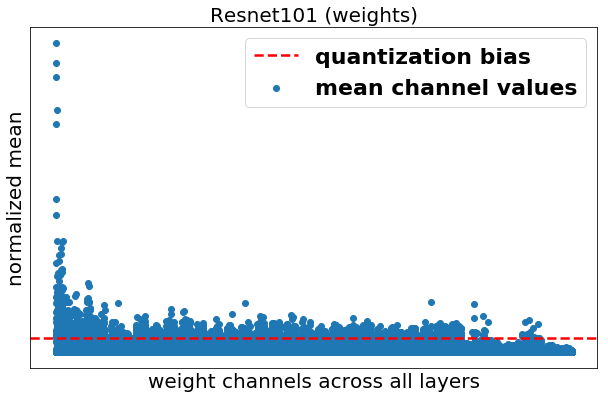

In [546]:
plt.rcParams["figure.figsize"] = [9,6]

plt.axhline(0.5, color='r', lw=2.5, ls='--')
plt.scatter(np.arange(len(m_r)), m_r)

plt.xlabel('weight channels across all layers', size=20)
plt.ylabel('normalized mean', size=20)

plt.legend(['quantization bias', 'mean channel values'], loc='best', prop={'size': 22, 'weight': 'bold'})
plt.tick_params(axis='both', which='major', labelsize=20)

plt.title('Resnet101 (weights)', fontsize=20)

plt.tight_layout()
_=plt.yticks([])
_=plt.xticks([])
plt.savefig('resnet101_bias_err.png')